<a href="https://colab.research.google.com/github/Adekoyaag/Adekoyaag/blob/main/Clustering_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up PySpark in Colab

In [1]:

!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless

In [2]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

--2022-05-11 19:36:54--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  59.9MB/s    in 5.3s    

2022-05-11 19:36:59 (48.8 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

Now that we have installed all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run Pyspark in the Colab environment.

In [5]:
import pyspark
import numpy as np
import pandas as pd

# Problem description
In this exercise, we will develop two classifiers to perform a binary classification task - The objective is to predict the big or small buyers in the Flamingo dataset (label 1) or not (label 0).

Data Preparation
Removing columns and rows
Import needed dataset from github


In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Buyers').getOrCreate()

# Read data from CSV file
#you can download it from here: https://raw.githubusercontent.com/besherh/BigDataManagement/main/SparkCSV/flights-larger.csv
df = spark.read.csv('combined-data.csv', sep=',', header=True, inferSchema=True, nullValue='NULL')
#df = pd.read_csv("combined-data.csv")



In [ ]:
#View table structure
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)



In [7]:
#Total number of records
df.count()


4619

In [8]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count

In [ ]:
#Check for missing values
#
df.na.drop().count()


1411

In [9]:
df.na.drop(how="any", thresh=2).show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
|   342|         5653|        1|     android|              36|         5|       null|     null|
|   849|         5654|        1|      iphone|              40|         5|       null|     null|
|  1277|         5655|        1|     win

Fill missing values with mean of column


In [10]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['count_buyId', 'avg_price'], 
    outputCols=["{}_imputed".format(c) for c in ['count_buyId', 'avg_price']]
    ).setStrategy("mean")

In [11]:
# Add imputation cols to df
df2 = imputer.fit(df).transform(df)

In [ ]:
df2.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|                  1|7.214323175053155|
|  1863|         5651|        1|     android|              35|         4|       null|     null|                  1|7.214323175053155|
|   937|         5652|        1|     android|              39|

In [ ]:
df2.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- count_buyId_imputed: integer (nullable = true)
 |-- avg_price_imputed: double (nullable = true)



In [12]:
#Create label whether user is a big buyer or small 

df_players = df2.withColumn('label', (df2.avg_price_imputed >=4).cast('integer'))


In [13]:
df_players.show(5)

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|label|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|    1|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|    1|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|                  1|7.214323175053155|    1|
|  1863|         5651|        1|     android|              35|         4|       null|     null|                  1|7.214323175053155|    1|
|   937|         565

In [14]:
dfplayers = df_players.select(['teamLevel','platformType','count_gameclicks','count_hits','count_buyId_imputed','avg_price_imputed','label']).show()

+---------+------------+----------------+----------+-------------------+-----------------+-----+
|teamLevel|platformType|count_gameclicks|count_hits|count_buyId_imputed|avg_price_imputed|label|
+---------+------------+----------------+----------+-------------------+-----------------+-----+
|        1|     android|              69|         8|                  1|7.214323175053155|    1|
|        1|      iphone|              31|         5|                  1|7.214323175053155|    1|
|        1|      iphone|              26|         2|                  1|7.214323175053155|    1|
|        1|     android|              35|         4|                  1|7.214323175053155|    1|
|        1|     android|              39|         0|                  1|              1.0|    0|
|        1|     android|              36|         5|                  1|7.214323175053155|    1|
|        1|      iphone|              40|         5|                  1|7.214323175053155|    1|
|        1|     windows|      

In [ ]:
dfplayers.show(5)

In [15]:
#Categorical transformation of PlatformType column to indexed numerical value

from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='platformType', outputCol='platformType_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(df_players)



In [16]:
# Indexer creates a new column with numeric index values
platformType_idx = indexer_model.transform(df_players)

# Repeat the process for the other categorical feature
#platformType_idx = StringIndexer(inputCol='platformType', outputCol='platformType_idx').fit(df_players).transform(df_players)


In [17]:
df_players.columns

['userId',
 'userSessionId',
 'teamLevel',
 'platformType',
 'count_gameclicks',
 'count_hits',
 'count_buyId',
 'avg_price',
 'count_buyId_imputed',
 'avg_price_imputed',
 'label']

In [18]:
#Assembling columns

from pyspark.ml.feature import VectorAssembler

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'teamLevel', 'count_gameclicks', 'count_hits',
    'count_buyId_imputed', 
    'avg_price_imputed'
    
], outputCol='features')

# Consolidate predictor columns
buyers_assembled = assembler.transform(df_players)

# Check the resulting column
buyers_assembled.select('features', 'label').show(5, truncate=False)

+------------------------------------+-----+
|features                            |label|
+------------------------------------+-----+
|[1.0,69.0,8.0,1.0,7.214323175053155]|1    |
|[1.0,31.0,5.0,1.0,7.214323175053155]|1    |
|[1.0,26.0,2.0,1.0,7.214323175053155]|1    |
|[1.0,35.0,4.0,1.0,7.214323175053155]|1    |
|[1.0,39.0,0.0,1.0,1.0]              |0    |
+------------------------------------+-----+
only showing top 5 rows



In [20]:
buyers_assembled.show(2)

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|label|            features|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|    1|[1.0,69.0,8.0,1.0...|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|    1|[1.0,31.0,5.0,1.0...|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+
only showing top 2 rows



In [21]:
import pyspark
import numpy as np
import pandas as pd

In [22]:

from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(buyers_assembled)
data_scale_output=data_scale.transform(buyers_assembled)
data_scale_output.show(2)

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|label|            features|        standardized|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+--------------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|    1|[1.0,69.0,8.0,1.0...|[0.51957159924961...|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|    1|[1.0,31.0,5.0,1.0...|[0.51957159924961...|
+------+-------------+---------+------------+----------------+----------+-----------+-----

Now that our data is standardized we can develop the K Means algorithm. K-means is one of the most commonly used clustering algorithms for grouping data into a predefined number of clusters.

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.6352423282139211
Silhouette Score: 0.6339155896365148
Silhouette Score: 0.4455197184838785
Silhouette Score: 0.46735290203286245
Silhouette Score: 0.5274610856436776
Silhouette Score: 0.5423794767938335
Silhouette Score: 0.47988102082353556
Silhouette Score: 0.41436702062328706


Silhouette Score using ClusteringEvaluator() measures how close each point in one cluster is to points in the neighboring clusters thus helping in figuring out clusters that are compact and well-spaced out.

Text(0, 0.5, 'cost')

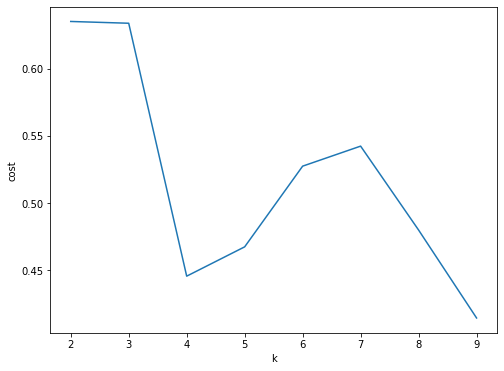

In [24]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Highest value gotten is between when k = 2 or 3; 

In [27]:
final_clustering=KMeans(featuresCol='standardized', k=3)
KMeans_fit=KMeans_algo.fit(data_scale_output)
clusters_output=KMeans_fit.transform(data_scale_output)


In [28]:
#notice the last column [prediction]
clusters_output.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+--------------------+----------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|label|            features|        standardized|prediction|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+-----+--------------------+--------------------+----------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|7.214323175053155|    1|[1.0,69.0,8.0,1.0...|[0.51957159924961...|         0|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|7.214323175053155|    1|[1.0,31.0,5.0,1.0...|[0.51957159924961...|         0|
|  1589|         5650|        1|   

# **Decision Tree**
Train/test split
To objectively assess a Machine Learning model you need to be able to test it on an independent set of data. You can't use the same data that you used to train the model: of course the model will perform (relatively) well on those data!

You will split the data into two components:

training data (used to train the model) and
testing data (used to test the model).

In [ ]:
# Split into training and test sets in a 80:20 ratio
buyers_train, buyers_test = buyers_assembled.randomSplit([0.8, 0.2], seed=17)

# Check that training set has around 80% of records
training_ratio = buyers_train.count() / buyers_assembled.count()
print(training_ratio)

0.7977917298116476


In [ ]:
buyers_test.show

<bound method DataFrame.show of DataFrame[userId: int, userSessionId: int, teamLevel: int, platformType: string, count_gameclicks: int, count_hits: int, count_buyId: int, avg_price: double, count_buyId_imputed: int, avg_price_imputed: double, Buyers: int, features: vector]>

# Build a Decision Tree
Now that you've split the flights data into training and testing sets, you can use the training set to fit a Decision Tree model.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(buyers_train)


In [ ]:
# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(buyers_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+-----------+
|label|prediction|probability|
+-----+----------+-----------+
|1    |1.0       |[0.0,1.0]  |
|0    |0.0       |[1.0,0.0]  |
|1    |1.0       |[0.0,1.0]  |
|1    |1.0       |[0.0,1.0]  |
|1    |1.0       |[0.0,1.0]  |
+-----+----------+-----------+
only showing top 5 rows



# Evaluate the Decision Tree
You can assess the quality of your model by evaluating how well it performs on the testing data. Because the model was not trained on these data, this represents an objective assessment of the model.

A confusion matrix gives a useful breakdown of predictions versus known values. It has four cells which represent the counts of:

True Negatives (TN) — model predicts negative outcome & known outcome is negative
True Positives (TP) — model predicts positive outcome & known outcome is positive
False Negatives (FN) — model predicts negative outcome but known outcome is positive
False Positives (FP) — model predicts positive outcome but known outcome is negative.

In [ ]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    5|
|    0|       0.0|  146|
|    1|       1.0|  782|
|    0|       1.0|    1|
+-----+----------+-----+

0.9935760171306209


# Logistic Regression
Build a Logistic Regression model
You've already built a Decision Tree model using the Team Buyers data. Now you're going to create a Logistic Regression model on the same data.

In [ ]:
buyers_train.columns

['userId',
 'userSessionId',
 'teamLevel',
 'platformType',
 'count_gameclicks',
 'count_hits',
 'count_buyId',
 'avg_price',
 'count_buyId_imputed',
 'avg_price_imputed',
 'label',
 'features']

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Selecting numeric columns
buyers_train_num = buyers_train.select("teamLevel", 'count_gameclicks', 'count_hits','count_buyId_imputed','avg_price_imputed', 'features', 'label')
buyers_test_num = buyers_test.select("teamLevel", 'count_gameclicks', 'count_hits','count_buyId_imputed','avg_price_imputed', 'features', 'label')

# Create classifier object and train on training data
logistic = LogisticRegression().fit(buyers_train_num)

# Create a predictions for the test data and show confusion matrix
prediction = logistic.transform(buyers_test_num)
prediction.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  147|
|    1|       1.0|  787|
+-----+----------+-----+



# Evaluate the Logistic Regression model
Accuracy is generally not a very reliable metric because it can be biased by the most common target class.

There are two other useful metrics:

# precision and recall.
Precision is the proportion of positive predictions which are correct. For all buyers which are predicted to be big , what proportion is actually big or small?

Recall is the proportion of positives outcomes which are correctly predicted. For all big buyers, what proportion is correctly predicted by the model?

The precision and recall are generally formulated in terms of the positive target class. But it's also possible to calculate weighted versions of these metrics which look at both

In [ ]:
# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall   = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator()
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

precision = 1.00
recall   = 1.00
